In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xml.etree.ElementTree as etree
import time
import os
import pickle
import joblib
import requests

import cv2

# used only for visualizing HOG (it is way more complex in opencv)
from skimage import feature

from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, classification_report, roc_curve, auc, accuracy_score, f1_score, make_scorer

from google.colab import files

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#reproducability!
random_seed = 27
import random
random.seed(random_seed)
np.random.seed(random_seed)

# Cells Classification

Abstract

The count of different types of blood cells is a widely used to detect abnormalities and to diagnose different diseases. For example, WBCs are an important part of the immune system and having a higher or lower number of WBCs than normal may indicate an underlying immune deficiency. Based on a set of annotated images with blood smears, we extract the separate cells, extract features and try to classify them in three categories - RBCs, WBCs and platelets. However, the current process is too limited as it depends on the current image dataset, its distribution and . It is necessary that further tests, investigation and improvements to be made.


## Introduction

The main task of this notebook is trying to classify blood cells from a dataset with blood smears including various types of cells with different types, coloring, shapes, etc. The main dataset that we will use is https://mahmudulalam.github.io/Complete-Blood-Cell-Count-Dataset/ (https://github.com/Shenggan/BCCD_Dataset). It contains around 410 blood smear images with more than 4500 annotated cell types.

## Features extraction

First, we investigate the data and try to extract the data in an appropriate format for further modelling.

###Loading dataset
First, we load the images from the dataset.  It contains the images with blood cells and xml files with anotations for the three basic types of cells - RBC - red blood cells (erythrocytes), WBC - white blood cells (leukocytes) and platelets (thrombocytes). 

In [3]:
def read_image(filepath, extension='.jpg', cvflags = cv2.IMREAD_ANYCOLOR):
    image = None
    if(os.path.isfile(filepath) and filepath.endswith(extension)):
        image = cv2.imread(filepath, flags = cvflags)
    return image

def read_text(filepath):
    content = None
    if(os.path.isfile(filepath)):
        with open(filepath) as f:
            content = f.read()
        return content

def read_image_by_url(url):
    """
    read an image by a given url containing an image
    """
    response = requests.get(url, stream = True).raw
    image = np.asarray(bytearray(response.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return image

def read_text_by_url(url):
    """
    read a text file by a given url containing a text
    """
    response = requests.get(url, stream = True)
    return response.content

### Extracting Annotations

Then we try to extract the separate cells from the images using the annotations. Actually, the annotations are in Pascal VOC format depicting the coordinates of the enclosing rectangle around each cell.

>Note:
>Pascal VOC XML annotation format is originally created for the Visual Object Challenge (VOC) but it has become a common format for object detection labels. It's well-specified and can be exported from many labeling tools. VoTT (https://github.com/microsoft/VoTT) is an example of an open source annotation and labeling tool for image and video assets.

An example of the Pascal VOC XML (at least the part that concerns us):

```
<annotation>
	<folder>JPEGImages</folder>
	<filename>BloodImage_00000.jpg</filename>
      ...
	<object>
		<name>WBC</name>
         ...
		<bndbox>
			<xmin>260</xmin>
			<ymin>177</ymin>
			<xmax>491</xmax>
			<ymax>376</ymax>
		</bndbox>
```


In [4]:
def find_bounding_boxes(xml_as_string):
    labels = set()
    items = np.array([])
    
    xml = etree.fromstring(xml_as_string)
    if(not(xml is None)):   
        
        image_name, image_extension = os.path.splitext(xml.find('filename').text)
        objects = [] 
        for i, obj in enumerate(xml.iter('object')):
            object_number = str(i + 1).zfill(5) 
            object_name = f"{image_name}_{object_number}"
            object_label = obj.find('name').text 
            object_bounding_box = obj.find('bndbox')
            labels.add(object_label)

            items = np.append(items, {
                'object_number': object_number,
                'name': object_name, 
                'xmin': object_bounding_box.find('xmin').text,
                'xmax': object_bounding_box.find('xmax').text, 
                'ymin': object_bounding_box.find('ymin').text, 
                'ymax': object_bounding_box.find('ymax').text, 
                'label': object_label
            })

    return { 'items': items, 'labels': labels }

Let's look the annotations. Now, we can see the bounding boxes around each cell together with their labels.

In [5]:
def show_image_with_bounding_boxes(image, image_title, bounding_boxes):
    fig,ax = plt.subplots(1, figsize=(10, 10))
    clone = image.copy()
    if(bounding_boxes is not None):
        for bounding_box in bounding_boxes:
            xmin, xmax = int(bounding_box.get('xmin')), int(bounding_box.get('xmax'))
            ymin, ymax = int(bounding_box.get('ymin')), int(bounding_box.get('ymax'))

            label = bounding_box.get('label')
            clone = cv2.rectangle(clone,
                                  (xmin, ymin),
                                  (xmax, ymax),
                                  (0, 0, 255),
                                  2);
            cv2.putText(clone,
                        label, 
                        (xmin+5, ymin+15), 
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, 
                        (0, 0, 255),
                        2)
    
    ax.imshow(clone)
    ax.set_title(image_title)
    ax.axis('off')
    plt.show()

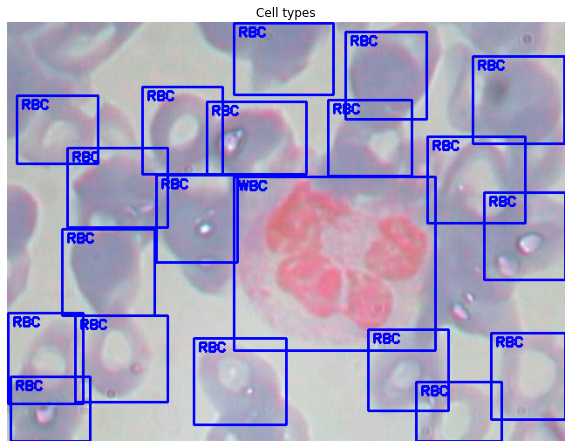

In [6]:
URL = "https://raw.githubusercontent.com/Shenggan/BCCD_Dataset/master/BCCD"
sample_image_file_name = f"BloodImage_{str(0).zfill(5)}"
sample_image_path = f"{URL}/JPEGImages/{sample_image_file_name}.jpg"
sample_annotations_path = f"{URL}/Annotations/{sample_image_file_name}.xml"

sample_image = read_image_by_url(sample_image_path)
sample_labels_file = read_text_by_url(sample_annotations_path)

bounding_boxes = find_bounding_boxes(sample_labels_file)
show_image_with_bounding_boxes(sample_image, "Cell types", bounding_boxes.get("items"))

### Extracting image vectors

Now, we will make a set of separate images with the different types of cells - RBC, WBC and platelets. The idea is to create samples for our classifier.

##### Resize

 We can have separate cell images in grayscale and resize them to the same size - 64 x 64 or (4096, 1) vector. While resizing we try to save the ratio and add some padding around the borders as we duplicate a little bit - cv2.BORDER_REPLICATE. Hopefully, the padding will not add too much artifacts. Also,unfortunately, in this way the differences with sizes will be lost, but we can add that afterwards as a subsequent feature. Although maybe in our dataset we do not have any knowledge of the magnification of the histology images, so we cannot calculate the size in $\mu m$, which would be a better feature than pixels and it will be more robust for similar images from new datasets.

In [7]:
def resize_to_closest_square_size(image, desired_size):
    """
    resize to the closest size to our desired one
    """
    old_width, old_height = image.shape
    ratio = float(desired_size) / max(old_width, old_height)
    new_width, new_height = int(old_width * ratio), int(old_height * ratio)
    image = cv2.resize(image, (new_width, new_height))
    return (image, new_width, new_height)

def resize_with_padding(image, desired_size, border_type = cv2.BORDER_REPLICATE):
    image, new_width, new_height = resize_to_closest_square_size(image, desired_size)

    delta_width = desired_size - new_width
    delta_height = desired_size - new_height

    top = delta_height//2
    bottom = delta_height - top
    left = delta_width//2
    right = delta_width - left
 
    color = [0, 0, 0]
    new_image = cv2.copyMakeBorder(image, top, bottom, left, right, border_type, value=color)
    return new_image


##### Preprocess cell image sample 
As in the previous part of EDA and features extraction (https://github.com/teodora-petkova/Artificial-Intelligence-Course/blob/master/Data-Science/Trials/Blood%20Cells%20Features%20Extraction.ipynb we do a little bit of preprocessing 
 * increase the contrast with CLAHE, as the image are little bit more brighter and most of their pixels have high values
 * turn to grayscale - easier to work with one channel (maybe in further improvements it will be better to include the processing on all channels separately)

In [8]:
def increase_contrast(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8,8))
    l2 = clahe.apply(l)

    lab = cv2.merge((l2,a,b))
    img2 = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR) 
    
    return img2

def preprocess(image):
    image_with_increased_contrast = increase_contrast(image)

    gray_image = cv2.cvtColor(image_with_increased_contrast, cv2.COLOR_RGB2GRAY)
  
    return gray_image

def find_cell_edges(grayscale_image):
    smoothen_image = cv2.GaussianBlur(grayscale_image, (3, 3), 0)

    otsu_threshold, otsu_image = cv2.threshold(smoothen_image, 0, 255,
                                               cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    image_closed_otsu = cv2.morphologyEx(otsu_image, cv2.MORPH_CLOSE, 
                                         structuring_element, iterations = 3)
    
    canny_image = cv2.Canny(image_closed_otsu, otsu_threshold, 0.1*otsu_threshold)
    
    return canny_image

##### Image vectors with labels

Now, we will extract the image vectors with their labels from all the images of the datasets - around 410 (some indices are missing).

In [9]:
class CellImage:
    
    def __init__(self, image, base_file_name):
        self.original_image = image 
        self.base_file_name = base_file_name

    def resize(self, dimension):
        processed_image = preprocess(self.original_image)
        resized_image = resize_with_padding(processed_image, dimension)
        return resized_image

    def size(self):
        return self.original_image.shape

In [10]:
def crop_image(image, xmin, xmax, ymin, ymax):
    # check for incorrect annotations of the bounding box
    if(ymax - ymin > 0 and xmax - xmin > 0):
        cropped_image = image[ymin:ymax, xmin:xmax]
        return cropped_image
    else: 
        return None

def get_cell_image_by_bounding_box(image, bounding_box, dimension):
    xmin, xmax = int(bounding_box.get('xmin')), int(bounding_box.get('xmax'))
    ymin, ymax = int(bounding_box.get('ymin')), int(bounding_box.get('ymax'))

    return crop_image(image, xmin, xmax, ymin, ymax)


def extract_image_samples(URL):
    
    min_index, max_index = 0, 411
    dimension = 64
    
    images_count = max_index - min_index
    images = np.array([])
    labels = np.array([])

    for i in range(min_index, max_index):
        # images & annotations paths
        image_file_name = f"BloodImage_{str(i).zfill(5)}"
        image_path = f"{URL}/JPEGImages/{image_file_name}.jpg"
        annotations_path = f"{URL}/Annotations/{image_file_name}.xml"

        # read data - images with annotations
        image = read_image_by_url(image_path)
        text = read_text_by_url(annotations_path)

        # check for missing images with the sequential indices
        if (image is not None and text is not None):
            bounding_boxes = find_bounding_boxes(text).get('items')

            if(len(bounding_boxes) > 0):
                for bounding_box in bounding_boxes:
                    cropped_cell = get_cell_image_by_bounding_box(image, bounding_box, dimension)

                    if(cropped_cell is not None):
                        images = np.append(images, CellImage(cropped_cell, image_file_name))
                        labels = np.append(labels, bounding_box.get('label'))

    return images, labels


In [11]:
start_time = time.time()

cell_images, cell_labels = extract_image_samples(URL)

print("Images shape:", cell_images.shape)
print("Labels shape:", cell_labels.shape)

end_time = time.time()
elapsed_time = end_time - start_time
print("Total elapsed time:", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Images shape: (4886,)
Labels shape: (4886,)
Total elapsed time: 00:03:06


#### Features

Apart from the actual image vector (64 x 64), we can try to retrieve other features for the classification.

* HOG 
* size of the bounding box 
* mean color intensity

Although maybe the size and the colour are not the best features as they depend heavily on this particular dataset - its dimensions and colour marking.

##### HOG

One of the most popular feature descriptors used for object detection is HOG or Histogram of oriented gradients. It focuses on the structure and the shape of the object by extracting the gradient and the orientation (i.e. the magnitude and the direction) of the edges calculated in ‘localized’ portions. This means that the complete image is broken down into smaller regions and for each region, the gradients and orientation are calculated.
Gradient:

$$ ∇f(x)= \left[ \frac{∂I}{∂x}, \frac{∂I}{∂y}\right]$$

* the magnitude is an indication of the slope or strength of the variation
$$ ||∇f(x)|| = \sqrt {(\frac{∂f}{dx})^{2}+(\frac{∂f}{∂y})^{2}} $$ 
* the orientation points in the direction of the most rapid increase in intensity (the steepest ascent)
$$ \theta = {tan{^{-1}}} \left[{\frac{∂f}{∂y}}/{\frac{∂f}{∂x}}\right] $$

Process:
* calculate the gradients for both x and y direction separately for all the pixels in the image => using a Sobel Kernel of size 1.
* calculate the magnitude and orientation using gx and gy
* calculate Histogram of Gradients in smaller cell e.g. 8×8 cells (9×1)
   ```
   for each pixel value
      find the orientation of the pixel
      choose a bigger bin value than 1 in order to have less buckets for the frequency table e.g. 16
      sum the gradient values in the bins instead of measuring only the orientation values
      but also add weight in order to take into account the contribution of a pixel’s gradient to the bins on both sides.
    ```
* normalize gradients in a bigger cell e.g. 16×16 cell (36×1) in order to  reduce this lighting variation
  $$V = (a_1, a_2, ..., a_{36})$$
  $$k = \sqrt{a_1^2+ a_2^2+a_3^2+ … +a_{36}^2}$$
  $$|v| = (a_1/k, a_2/k, ...,a_{36})/k$$

* combine all these to get the features for the final image 
for our 64x64 image with 8x8 cells => 64x1 vector for the HOG feature


In [12]:
"""
def get_hog_features_test(image):
  # a very simple implementation without normalisation/optimization
  # source: https://docs.opencv.org/master/dd/d3b/tutorial_py_svm_opencv.html
  
  gx = cv2.Sobel(image, cv2.CV_32F, 1, 0,	ksize = 1)
  gy = cv2.Sobel(image, cv2.CV_32F, 0, 1,	ksize = 1)

  magnitude, angle = cv2.cartToPolar(gx, gy) # angle range -> 0 to 360
  
  bin_number = 16
  bins = np.int32(bin_number * angle  / (2*np.pi)) # quantizing binvalues in (0...16)
  
  bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
  magnitude_cells = magnitude[:10,:10], magnitude[10:,:10], magnitude[:10,10:], magnitude[10:,10:]

  hists = [np.bincount(b.ravel(), m.ravel(), bin_number) for b, m in zip(bin_cells, magnitude_cells)]
  
  hist = np.hstack(hists) # hist is a 64 vector
  return hist
"""

def get_hog_features(image):
  cell_size = (8, 8)
  block_size = (2, 2)
  bins_number = 8

  # win_size = the size of the image cropped to an multiple of the cell size
  # cell_size = the size of the cells of the img patch over which to calculate the histograms
  # block_size = the number of cells which fit in the patch
  hog = cv2.HOGDescriptor(_winSize = img.shape,
                          _blockSize = (block_size[0] * cell_size[0], block_size[1] * cell_size[1]),
                          _blockStride = cell_size,
                          _cellSize = cell_size,
                          _nbins = bins_number)


  hist = hog.compute(img)
  return hist.reshape(1, -1)[0]

### Creating DataFrame

First, we try to visualize a couple of images generated by the extraction and look at the possible features we can extract from then e.g. the hog descriptor. Unfortunately, we cannot use contour features for the cells as our edge detection is not very successful.

In [13]:
def show_images(images, titles, fig_title=None, fig_width = 13, fig_height = 5):
    assert(len(images) == len(titles))

    fig = plt.figure(figsize=(fig_width, fig_height), constrained_layout=True)
    fig.suptitle(fig_title, fontsize = 20)

    i = 1
    for image, title in zip(images, titles):
        plt.subplot(1, len(images), i)
        plt.imshow(image, cmap=plt.cm.gray)
        plt.title(title , fontsize = 20)
        plt.axis('off')
        i += 1

    plt.show()

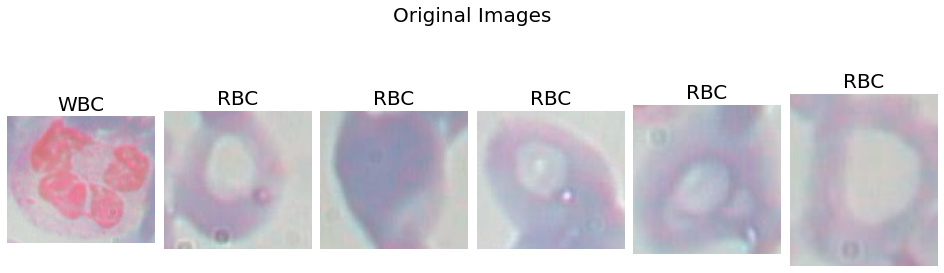

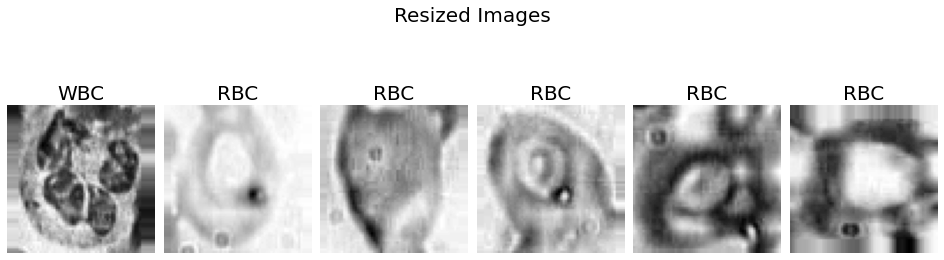

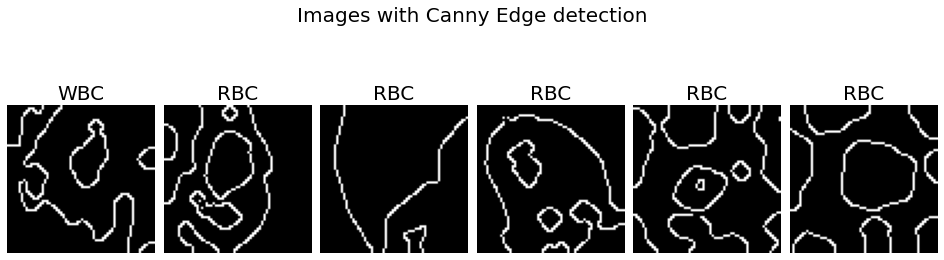

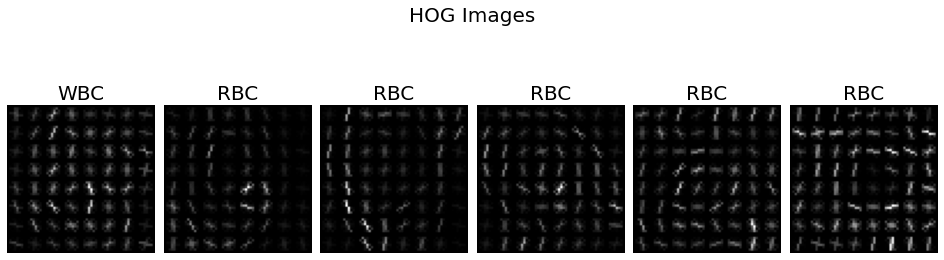

In [14]:
def contours(image):
  img = image.copy()
  contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  img = cv2.drawContours(img, contours, -1, (0, 255, 0), 3)
  return img

def hog_skimage(img):
  # the normalization is different than opencv and it is slower
  (hog, hog_image) = feature.hog(img,
                                 orientations=8, 
                                 pixels_per_cell=(8, 8), 
                                 cells_per_block=(2, 2), 
                                 block_norm='L2-Hys', 
                                 visualize=True)
  return hog_image

range_cells = range(0, 6)

sample_cells = [img.original_image for img in cell_images[range_cells]]
sample_resized_cells = [img.resize(64) for img in cell_images[range_cells]]
sample_canny_cells = [find_cell_edges(img) for img in sample_resized_cells]
#sample_contours_cells = [contours(img) for img in sample_canny_cells]
sample_hog_cells = [hog_skimage(img) for img in sample_resized_cells]

show_images(sample_cells, cell_labels[range_cells], fig_title="Original Images")
show_images(sample_resized_cells, cell_labels[range_cells], fig_title="Resized Images")
show_images(sample_canny_cells, cell_labels[range_cells], fig_title="Images with Canny Edge detection")
#show_images(sample_contours_cells, labels[range_cells], fig_title="Images with Contours")
show_images(sample_hog_cells, cell_labels[range_cells], fig_title="HOG Images")


In [15]:
data = []
for cell_image, cell_label in zip(cell_images, cell_labels):
  img = cell_image.resize(64)
  hog_features = get_hog_features(np.float32(img))
  hog_features = hog_features
  w, h, _ = cell_image.original_image.shape
  bgr = cv2.mean(cell_image.original_image)
  
  data.append([np.float32(img.flatten()), hog_features, w, h, bgr[2], bgr[1], bgr[0], cell_label])

cells_data = pd.DataFrame(data, columns=["image_vector",
                                         "hog", 
                                         "bounding_box_width", 
                                         "bounding_box_height", 
                                         "mean_red_color_intensity",
                                         "mean_blue_color_intesity", 
                                         "mean_green_color_intensity",
                                         "cell_type"])

Let's see our generated dataframe

In [16]:
cells_data.head()

,image_vector,hog,bounding_box_width,bounding_box_height,mean_red_color_intensity,mean_blue_color_intesity,mean_green_color_intensity,cell_type
0,"[119.0, 119.0, 119.0, 119.0, 119.0, 132.0, 145...","[0.2553941, 0.20481467, 0.10642669, 0.1798552,...",199,231,179.993735,163.922230,200.864474,WBC
1,"[251.0, 251.0, 251.0, 250.0, 250.0, 248.0, 248...","[0.060712524, 0.028036268, 0.018205276, 0.0595...",99,106,194.654183,187.778826,192.074138,RBC
2,"[245.0, 245.0, 245.0, 243.0, 243.0, 245.0, 246...","[0.34401095, 0.14461276, 0.039643016, 0.028980...",99,106,184.612540,170.316276,170.396131,RBC
3,"[248.0, 248.0, 248.0, 248.0, 248.0, 247.0, 249...","[0.18695585, 0.098287776, 0.14312449, 0.046448...",99,106,203.471603,191.363065,192.618258,RBC
4,"[158.0, 153.0, 152.0, 155.0, 157.0, 168.0, 182...","[0.12575586, 0.1817157, 0.20783614, 0.22725655...",93,92,194.761805,179.222651,180.636746,RBC


It is a good idea to save the extracted features in order to reuse them and not to perform the whole process of feature extraction during modelling.

In [17]:
cells_data_file = os.path.join("cell_images_features.pkl")

In [18]:
with open(cells_data_file, 'w') as f:
  cells_data.to_pickle(cells_data_file) 

In [19]:
#files.download(cells_data_file)

stored_cells_data = pd.read_pickle(cells_data_file)

# check that everything is retrieved successfully!
print("image vector size:", len(stored_cells_data.iloc[0].image_vector))
print("hog descriptor size:", len(stored_cells_data.iloc[0].hog))
print("Loaded cells data shape:", stored_cells_data.shape)

stored_cells_data.head()

image vector size: 4096
hog descriptor size: 1568
Loaded cells data shape: (4886, 8)


,image_vector,hog,bounding_box_width,bounding_box_height,mean_red_color_intensity,mean_blue_color_intesity,mean_green_color_intensity,cell_type
0,"[119.0, 119.0, 119.0, 119.0, 119.0, 132.0, 145...","[0.2553941, 0.20481467, 0.10642669, 0.1798552,...",199,231,179.993735,163.922230,200.864474,WBC
1,"[251.0, 251.0, 251.0, 250.0, 250.0, 248.0, 248...","[0.060712524, 0.028036268, 0.018205276, 0.0595...",99,106,194.654183,187.778826,192.074138,RBC
2,"[245.0, 245.0, 245.0, 243.0, 243.0, 245.0, 246...","[0.34401095, 0.14461276, 0.039643016, 0.028980...",99,106,184.612540,170.316276,170.396131,RBC
3,"[248.0, 248.0, 248.0, 248.0, 248.0, 247.0, 249...","[0.18695585, 0.098287776, 0.14312449, 0.046448...",99,106,203.471603,191.363065,192.618258,RBC
4,"[158.0, 153.0, 152.0, 155.0, 157.0, 168.0, 182...","[0.12575586, 0.1817157, 0.20783614, 0.22725655...",93,92,194.761805,179.222651,180.636746,RBC


## Modelling 

###Preprocessing data

First, we will try to use only the raw image vectors.

In [20]:
cell_features = stored_cells_data.image_vector.tolist()
cell_labels = stored_cells_data.cell_type

#### Unbalanced dataset

Let's see what kind of samples do we have.

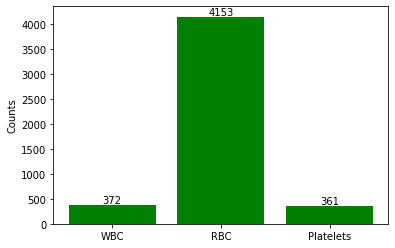

In [21]:
counts = Counter(cell_labels)
unique_cell_types = np.unique(cell_labels)
x = list(np.arange(0,len(unique_cell_types)))
rects = plt.bar(x, counts.values(), color="green")
plt.xticks(x, counts.keys())
plt.ylabel('Counts')
for rect in rects:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., 
             height,
             '%d' % int(height),
             ha='center', 
             va='bottom')
    
plt.show()

We can see that we have highly imbalanced classes. It is a problem because possibly any classification algorithm will predict RBC with the greatest probability.
Possible solutions:
* Random Oversampling: randomly duplicate samples in the minority class
* Random Undersampling: randomly delete samples in the majority class

Of course, both of them have their pros and cons but 
Random resampling provides a naive technique for rebalancing the class distribution for an imbalanced dataset. Actually in our case the data is representative as red cells are much more than white cells and platelets.

> RBCs account for approximately 40 to 45 percent of the blood. This percentage of blood made up of RBCs is a frequently measured number and is called the hematocrit. The ratio of cells in the normal blood is 600 RBCs for each white blood cell and 40 platelets.

In [22]:
#over = RandomOverSampler(sampling_strategy={"Platelets": 380}, random_state=random_seed)
#balanced_cell_features, balanced_cell_labels = over.fit_resample(cell_features, cell_labels)

#under = RandomUnderSampler(sampling_strategy={"RBC":800}, random_state=random_seed)
#balanced_cell_features, balanced_cell_labels = under.fit_resample(balanced_cell_features, balanced_cell_labels)

#print(Counter(balanced_cell_labels))

#### PCA

First, we will perform PCA (Principle Component Analysis) on the extracted images trying to take their charasteristic vectors and reduce the dimensions of the vector from (4096, 1) to (100, 1).

Principle Components are the linear combinations of the original variables in the dataset. PCA transforms the dataset into a new, lower-dimensional subspace, means into a new coordinate system.

Process:
* take the n-dimensional vector
* compute the mean vector for each dimension
* compute the covariance matrix.
* compute eigenvectors and corresponding eigenvalues for each dimension.


In [23]:
print("Each cell image features shape:", cell_features[0].shape)

images_pca = PCA(n_components=100, random_state=random_seed)
pca_fit = images_pca.fit(cell_features)
pcas = pca_fit.transform(cell_features)

print("Each cell image PCAs shape:", pcas[0].shape)

Each cell image features shape: (4096,)
Each cell image PCAs shape: (100,)


Now we can see a couple of the basis vectors, although they are not very comprehensive for us:

The number of the principal components: 100


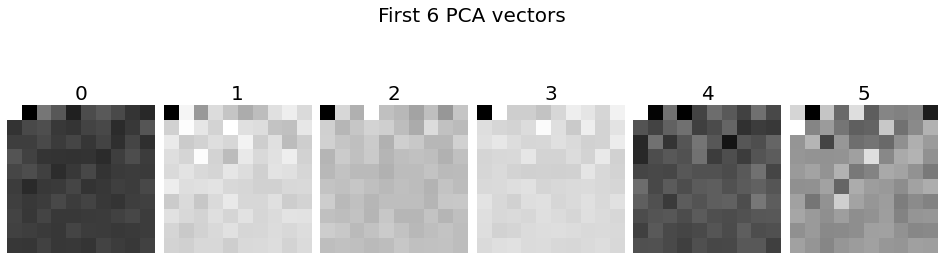

In [24]:
print("The number of the principal components:", len(pcas[0]))
pca_images = [im.reshape(10, 10) for im in pcas]
show_images(pca_images[0:6], np.arange(0, 6), "First 6 PCA vectors")

And actually we can see how much information is preserved with PCA. It is close to 95%.

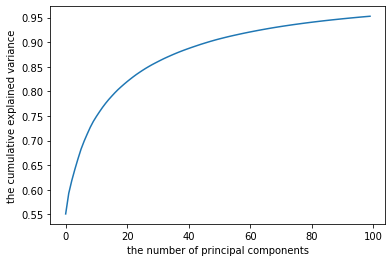

In [25]:
plt.plot(np.cumsum(pca_fit.explained_variance_ratio_))
plt.xlabel('the number of principal components')
plt.ylabel('the cumulative explained variance')
plt.show()

We can also see the transformed images and how much information they have preserved visually.

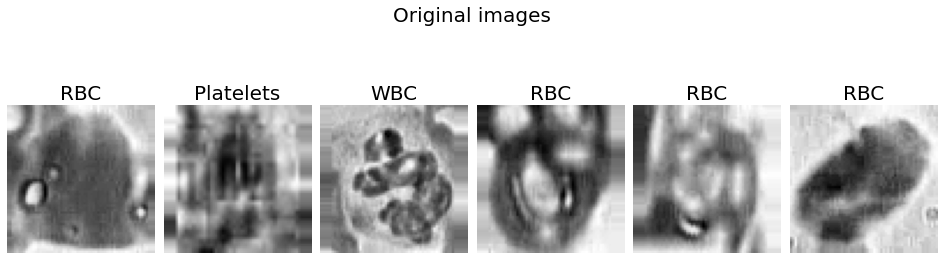

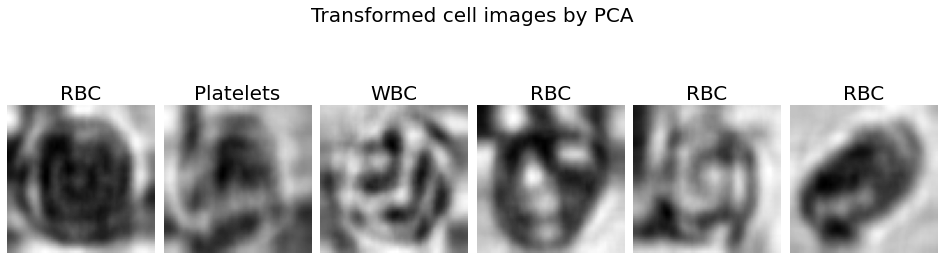

In [26]:
transformed_cells = [im.reshape(64, 64) for im in cell_features]
reversed_images = [im.reshape(64, 64) for im in pca_fit.inverse_transform(pcas)]

show_images(transformed_cells[70:76], cell_labels[70:76], "Original images")
show_images(reversed_images[70:76], cell_labels[70:76], "Transformed cell images by PCA")

In [27]:
# update cell features
cell_features = pcas

### Logistic Regression - baseline

As Logistic Regression is one of the basic simple and most commonly used ML algorithms, we can use it as a baseline for our modelling. Actually, Logistic Regression is used for binary classification i.e. two-class classification. It describes and estimates the relationship between one dependent binary variable and an independent one.

However, in our case we have three classes and we will use the multinomial logistic regression i.e. the target variable has three or more nominal categories such as predicting types of cells. Multinomial logistic regression uses again a linear function $f(k,i)$ to predict the probability that observation i has outcome k

$$f(k,i) = \beta_{0,k} + \beta_{1,k}x_{1,i} + \beta_{2,k}x_{2,i} + \cdots + \beta_{M,k}x_{M,i}$$

where $\beta_{m,k}$ is a regression coefficient associated with the mth explanatory/indepedent variable and the kth outcome.


In [28]:
lr = LogisticRegression(C = 1,
                        multi_class="multinomial",
                        solver="saga", # improved linear convergence
                        max_iter=2000)

lr_cells_train, lr_cells_test, lr_labels_train, lr_labels_test = train_test_split(cell_features,
                                                                                  cell_labels,
                                                                                  test_size=0.25,
                                                                                  stratify=cell_labels,
                                                                                  random_state=random_seed)
print(lr_cells_train.shape)
print(lr_labels_train.shape)
print(lr_cells_test.shape)
print(lr_labels_test.shape)

lr_res = lr.fit(lr_cells_train, lr_labels_train)

(3664, 100)
(3664,)
(1222, 100)
(1222,)


##### Scoring
Is the accuracy here the best?
For logistic regression score returns the mean accuracy on the given test data and labels.
But in multi-label classification, this is the subset accuracy which is not the best metric since you require for each sample that each label set be correctly predicted.

In [29]:
def show_scores(estimator, X_train, y_train, X_test, y_test):
  #return the mean accuracy on the given test data and labels.
  print("Train: ", estimator.score(X_train, y_train))
  print("Test: ", estimator.score(X_test, y_test)) 

In [30]:
show_scores(lr, lr_cells_train, lr_labels_train, lr_cells_test, lr_labels_test)

Train:  0.7366266375545851
Test:  0.7217675941080196


In [31]:
def show_confusion_matrices_and_report(estimator, X, y):

  predicted = estimator.predict(X)
  print(f"Classification report for classifier:\n {classification_report(y, predicted)}")

  matrix = plot_confusion_matrix(estimator, X, y,
                               cmap=plt.cm.Greens,
                               normalize='true')
  plt.title('Confusion matrix for our classifier in percentage')
  plt.show(matrix)

  matrix_num = plot_confusion_matrix(estimator, X, y, cmap=plt.cm.Greens)
  plt.title('Confusion matrix for our classifier with actual sample counts')
  plt.show(matrix_num)
  
  plt.show()

Classification report for classifier:
               precision    recall  f1-score   support

   Platelets       0.29      0.87      0.44        90
         RBC       1.00      0.71      0.83      1039
         WBC       0.30      0.70      0.42        93

    accuracy                           0.72      1222
   macro avg       0.53      0.76      0.56      1222
weighted avg       0.89      0.72      0.77      1222



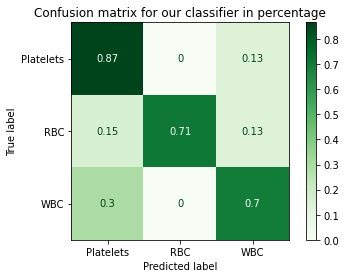

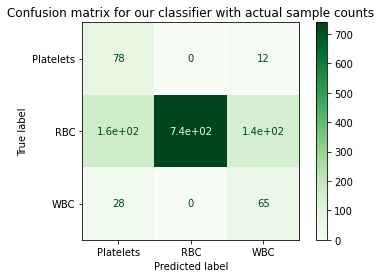

In [32]:
show_confusion_matrices_and_report(lr, lr_cells_test, lr_labels_test)

As a whole, as a simple algorithm Linear Regression performs quite well as a percentage of the predicted cell types. It predicts a lot of WBCs and Platelets, not only RBCs but unfortunalely the precision is quite low. 
There are a lot of false possitives i.e. RBCs which are defined as WBCs and Platelets. Overall, it is not a very good result as actually the occurence of more WBCs is a sign of a disease.

In [33]:
"""
# It could be useful to see the probabilities of each independent variable - each component of PCA. 
# However, maybe in our case it does not help with the general understanding.
def show_coeffs_probabilities(lr_classes, image_shape, classes_names):
  assert(len(lr_classes) == len(classes_names))
  i = 1
  num_classes = len(lr_classes)
  for lr_class in lr_classes:
    
    pixels=[]
    for p in lr_class:
      if p > 0:
        pixels.append((0,0,255))
      elif p < 0: 
        pixels.append((255,0,0))
      else:
        pixels.append((0,0,0))

    
    plt.subplot(1, num_classes, i)
    plt.imshow(np.array(pixels).reshape(image_shape))
    plt.title(classes_names[i-1], fontsize = 20)
    plt.axis('off')
    i += 1

  plt.show()

show_coeffs_probabilities(lr.coef_, (10, 10, 3), lr.classes_)
"""

"\n# It could be useful to see the probabilities of each independent variable - each component of PCA. \n# However, maybe in our case it does not help with the general understanding.\ndef show_coeffs_probabilities(lr_classes, image_shape, classes_names):\n  assert(len(lr_classes) == len(classes_names))\n  i = 1\n  num_classes = len(lr_classes)\n  for lr_class in lr_classes:\n    \n    pixels=[]\n    for p in lr_class:\n      if p > 0:\n        pixels.append((0,0,255))\n      elif p < 0: \n        pixels.append((255,0,0))\n      else:\n        pixels.append((0,0,0))\n\n    \n    plt.subplot(1, num_classes, i)\n    plt.imshow(np.array(pixels).reshape(image_shape))\n    plt.title(classes_names[i-1], fontsize = 20)\n    plt.axis('off')\n    i += 1\n\n  plt.show()\n\nshow_coeffs_probabilities(lr.coef_, (10, 10, 3), lr.classes_)\n"

### SVM

Now, let's try with a support vector machine (SVM). It is a type of supervised machine learning model used for regression, classification, and outlier detection.
An SVM model is a representation of the samples as points in space, mapped so that the samples of the separate categories are divided by a clear gap (i.e. hyperplane) that is as wide as possible. New examples are then mapped into that same space and predicted to belong to a category based on which side of the margain/gap they fall.
It is considered as an universal approximator because of the Kernel trick (Cover's theorem).

> *Hyperparameters*
> * gamma - how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’
> * C - regularisation -> for larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly; a lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy




In [34]:
svm_cells_train, svm_cells_test, svm_labels_train, svm_labels_test = train_test_split(cell_features,
                                                                                      cell_labels,
                                                                                      test_size=0.25,
                                                                                      stratify=cell_labels,
                                                                                      random_state=random_seed)
print(svm_cells_train.shape)
print(svm_labels_train.shape)
print(svm_cells_test.shape)
print(svm_labels_test.shape)

(3664, 100)
(3664,)
(1222, 100)
(1222,)


In [35]:
svm = SVC(kernel='rbf',
          C = 1, #default 
          gamma="scale", # default = 1 / (n_features * X.var())
          class_weight="balanced",
          decision_function_shape="ovr", #only option, ovo deprecated
          random_state=random_seed,
          probability=True)
svm.fit(svm_cells_train, svm_labels_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=27, shrinking=True, tol=0.001,
    verbose=False)

We have quite a small value of gamma, so in this way we have a smoother decision boundary as more points, not just the ones closer to the support vectors, influence it.

In [36]:
 print("Gamma hyperparameter:", 1 / (len(svm_cells_train) * svm_cells_train.var()))

Gamma hyperparameter: 7.288876319869978e-09


####Scoring

Classification report for classifier:
               precision    recall  f1-score   support

   Platelets       0.77      0.82      0.80        90
         RBC       1.00      0.97      0.98      1039
         WBC       0.72      0.88      0.79        93

    accuracy                           0.95      1222
   macro avg       0.83      0.89      0.86      1222
weighted avg       0.96      0.95      0.95      1222



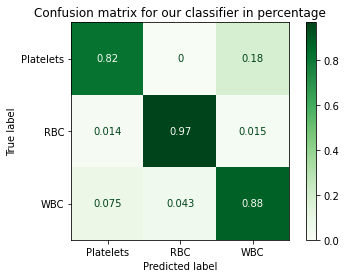

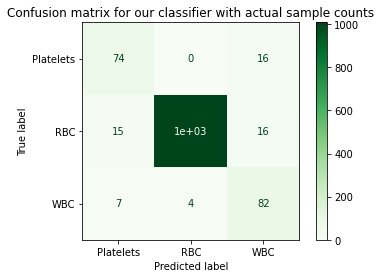

In [37]:
show_confusion_matrices_and_report(svm, svm_cells_test, svm_labels_test)

It seems that the result is similar as the baseline logistic regression maybe a little bit better. Actually, if we look at the percentage of predicted WBCs and Platelets the classifier seems to perform quite well. Even the precision is definitely higher than the one of LogisticRegression

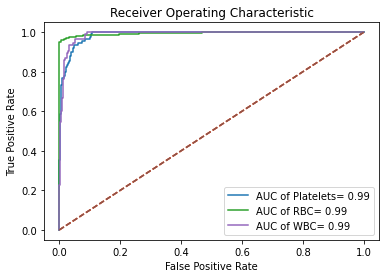

In [38]:
def get_index(class_name):
  return np.where(svm.classes_ == class_name)[0][0]

probabilities = svm.predict_proba(svm_cells_test)
#print(svm.classes_)

for class_name in svm.classes_:
  y_proba = probabilities[:, get_index(class_name)]
  false_positive_rate, true_positive_rate, thresholds = roc_curve(svm_labels_test, y_proba, pos_label=class_name)
  roc_auc = auc(false_positive_rate, true_positive_rate)

  roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label=f'AUC of {class_name}= {round(roc_auc, 2)}')
  plt.plot([0,1], [0,1], ls='--')

plt.title('Receiver Operating Characteristic')

plt.legend(loc=0)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

It seems that the current SVM predicts quite well test data from our current dataset. However, let's perform a grid search and see if we will again choose similar parameters for SVM based on f1-score.

In [39]:
k_fold = StratifiedKFold(n_splits = 3, shuffle = True)

parameters = {
    'C': [1e-3, 0.01, 1, 100],
    'gamma': [1e-9, 1e-6, 1e-3, 0.1] } 
f1_scorer = make_scorer(f1_score, average="weighted")
grid_search = GridSearchCV(SVC(kernel='rbf', class_weight='balanced', random_state=random_seed), 
                   parameters, 
                   scoring = f1_scorer, 
                   cv = k_fold)

grid_search.fit(svm_cells_train, svm_labels_train)

print("SVM best estimator:", grid_search.best_estimator_)
print("SVM best score:", grid_search.best_score_)

SVM best estimator: SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1e-06, kernel='rbf',
    max_iter=-1, probability=False, random_state=27, shrinking=True, tol=0.001,
    verbose=False)
SVM best score: 0.9249214347575546


Classification report for classifier:
               precision    recall  f1-score   support

   Platelets       0.87      0.60      0.71        90
         RBC       0.96      0.98      0.97      1039
         WBC       0.73      0.75      0.74        93

    accuracy                           0.94      1222
   macro avg       0.85      0.78      0.81      1222
weighted avg       0.94      0.94      0.94      1222



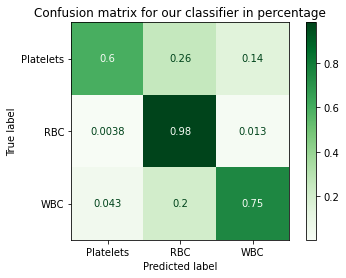

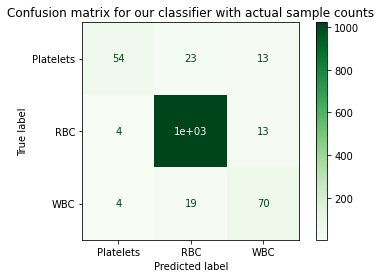

In [40]:
show_confusion_matrices_and_report(grid_search.best_estimator_, svm_cells_test, svm_labels_test)

Although the Grid Search choose C=100 over C=1, I think as the precision is better in the latter case, it is the better model for now. Although the Grid Search choose C=100 over C=1 again with very small gamma = 1e-09

In [42]:
filename = 'finalized_model.sav'
joblib.dump(svm, filename)

['finalized_model.sav']

Actual cell types:  ['RBC', 'Platelets', 'Platelets', 'Platelets', 'WBC', 'RBC']


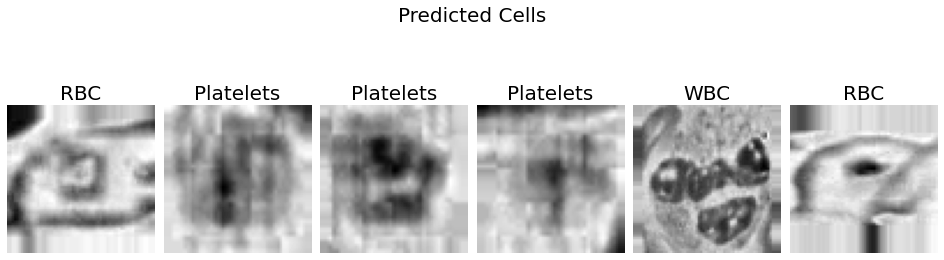

In [43]:
#just for visualisation purpose - completely inaccurate to test in this way
range_cells = np.arange(100, 106)

sample_cells = [img.reshape(64, 64) for img in stored_cells_data.image_vector[range_cells]]
predicted_labels = svm.predict(cell_features[range_cells]).tolist()
print("Actual cell types: ", cell_labels[range_cells].tolist())

show_images(sample_cells, predicted_labels, fig_title="Predicted Cells")

### Voting Classifier (unfinished...)

There is an idea to investigate an ensemble classifier combining two SVMs - one with raw features and one with hog features. But it is still in process of testing...

In [44]:
hog_features = stored_cells_data.hog.tolist()
hog_pca = PCA()
hog_features = hog_pca.fit_transform(hog_features)

hog_train, hog_test, hog_labels_train, hog_labels_test = train_test_split(hog_features, cell_labels)

svm_hog = SVC(kernel='rbf',
          class_weight="balanced",
          random_state=random_seed,
          probability=True)
svm_hog.fit(hog_train, hog_labels_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=27, shrinking=True, tol=0.001,
    verbose=False)

Classification report for classifier:
               precision    recall  f1-score   support

   Platelets       0.66      0.72      0.69        87
         RBC       0.96      0.95      0.96      1044
         WBC       0.80      0.77      0.79        91

    accuracy                           0.92      1222
   macro avg       0.81      0.82      0.81      1222
weighted avg       0.93      0.92      0.93      1222



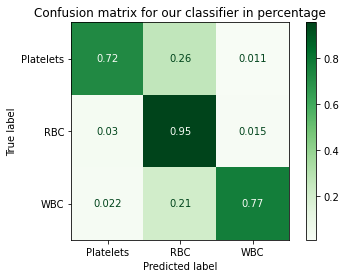

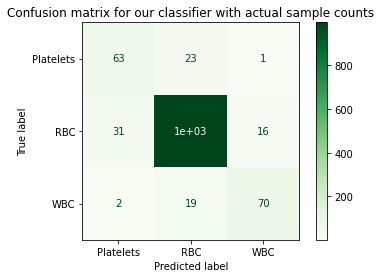

In [45]:
show_confusion_matrices_and_report(svm_hog, hog_test, hog_labels_test)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(cell_features, 
                                                    cell_labels, 
                                                    test_size=0.25,
                                                    stratify=cell_labels,
                                                    random_state=random_seed)
voting_clf = VotingClassifier(estimators=[('svc_raw', svm), ('svc_hog', svm_hog)],
                              voting='soft', weights=[1, 1])
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('svc_raw',
                              SVC(C=1, break_ties=False, cache_size=200,
                                  class_weight='balanced', coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='rbf', max_iter=-1,
                                  probability=True, random_state=27,
                                  shrinking=True, tol=0.001, verbose=False)),
                             ('svc_hog',
                              SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight='balanced', coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='rbf', max_iter=-1,
                                  probability=True, random_state=27,
                                  shrinking=True, tol=0.001, verbose=False))],
                 flatten_transfor

Classification report for classifier:
               precision    recall  f1-score   support

   Platelets       0.84      0.77      0.80        90
         RBC       0.99      0.99      0.99      1039
         WBC       0.79      0.85      0.82        93

    accuracy                           0.96      1222
   macro avg       0.87      0.87      0.87      1222
weighted avg       0.96      0.96      0.96      1222



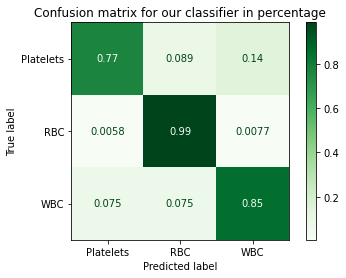

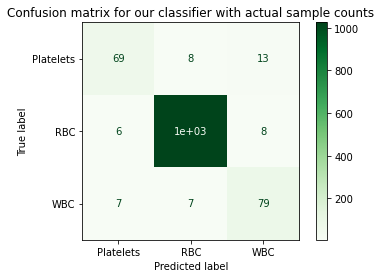

In [48]:
show_confusion_matrices_and_report(voting_clf, X_test, y_test)

## Conclusion

Cell classification is an important process toward further investigation of possible models for helping diagnoses for different types of blood cell. In this notebook, we look through very basic supervised classifiers trying to differentiate between main types of blood cells.

## Bibliography

1. OpenCV tutorials and documentation: 
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_tutorials.html + https://docs.opencv.org/master/

2. Adrian Rosebrock, https://www.pyimagesearch.com/

3. Sreenivas Bhattiprolu, Python for Microscopists: https://www.youtube.com/channel/UC34rW-HtPJulxr5wp2Xa04w

4. Computer Vision, Algorithms and Applications, Richard Szeliski - https://link.springer.com/book/10.1007/978-1-84882-935-0

5. Alexandre KOWALCZYK, https://www.svm-tutorial.com/

6. Jameela Alkrimi, Azizah Suliman, Classification Red Blood Cells Using Support Vector Machine, https://www.researchgate.net/publication/281208389_Classification_Red_Blood_Cells_Using_Support_Vector_Machine

7. Xin Zheng, Yong Wang, Fast and Robust Segmentation of White Blood Cell Images by Self-supervised Learning, https://www.researchgate.net/publication/322872863_Fast_and_Robust_Segmentation_of_White_Blood_Cell_Images_by_Self-supervised_Learning